In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTEN, ADASYN
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (accuracy_score, f1_score, 
                             confusion_matrix, classification_report)

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data = pd.read_csv("telcoChurn.csv")
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
data.shape

(7043, 21)

In [5]:
value_counts = data['Churn'].value_counts(normalize=True).sort_values(ascending=True)
value_counts

Churn
Yes    0.26537
No     0.73463
Name: proportion, dtype: float64

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
data.drop(data[data['TotalCharges'] == " "].index, axis=0, inplace=True)
data['TotalCharges'] = data['TotalCharges'].astype('float')
data.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [8]:
data.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [9]:
data.duplicated().sum()

0

In [10]:
data.drop(columns=['customerID'], axis=1, inplace=True)

In [11]:
def outliers_plot(data: pd.DataFrame = None, column: str = None):
    """
    Function to plot outliers of a given column in a DataFrame.
    
    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the data to be plotted.
    column : str
        Name of the column in the DataFrame to plot outliers for.
    """
    sns.boxplot(data=data, x=column)
    plt.title(f'Distribution of {column}')

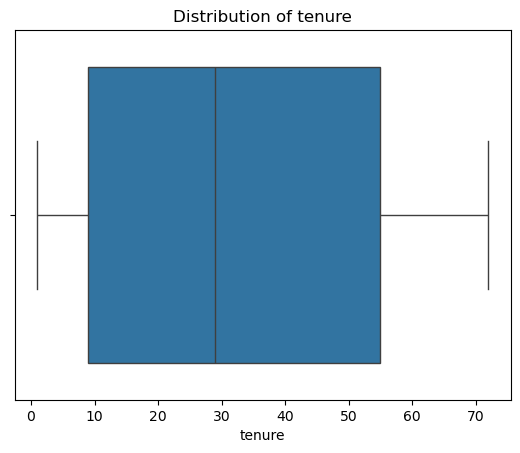

In [12]:
outliers_plot(data=data, column='tenure')

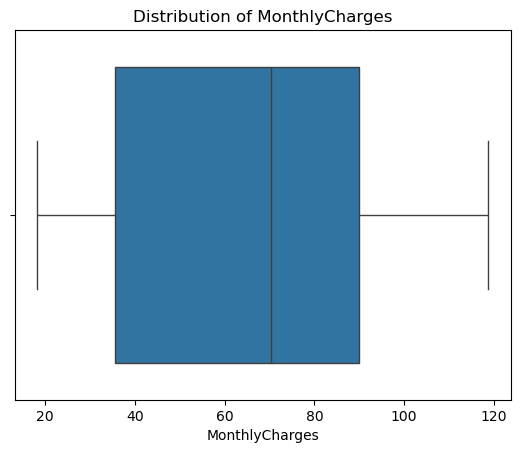

In [13]:
outliers_plot(data=data, column='MonthlyCharges')

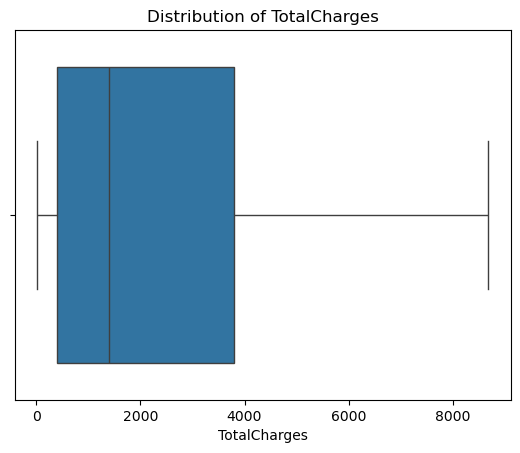

In [14]:
outliers_plot(data=data, column='TotalCharges')

In [15]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
binary_columns = ['Partner', 'Dependents', 'PaperlessBilling', 'Churn', 'PhoneService']
data[binary_columns] = data[binary_columns].map(lambda x: 1 if x == 'Yes' else 0)

In [17]:
data['gender'] = data['gender'].apply(lambda x: 1 if x == 'Female' else 0)
data['MultipleLines'] = data['MultipleLines'].map({'No phone service': 0, 'No': 0, 'Yes': 1})

internet_service_columns = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
data[internet_service_columns] = data[internet_service_columns].replace({'No internet service': 0, 'No': 0, 'Yes': 1})

categorical_columns = ['InternetService', 'Contract', 'PaymentMethod']
data = pd.get_dummies(data, columns=categorical_columns, drop_first=True, dtype='int')

C:\Users\prade\AppData\Local\Temp\ipykernel_19004\2534531928.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[internet_service_columns] = data[internet_service_columns].replace({'No internet service': 0, 'No': 0, 'Yes': 1})


In [18]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0
1,0,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1
3,0,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0


In [19]:
data['avg_monthly_value'] = data['TotalCharges'] / (data['tenure'] + 1)
data['tenure_ratio'] = data['tenure'] / (data['TotalCharges'] + 1)
data['service_density'] = data['OnlineSecurity'] + data['OnlineBackup'] + data['TechSupport']
data['tenure_MonthlyCharges'] = data['tenure'] * data['MonthlyCharges']

In [20]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,avg_monthly_value,tenure_ratio,service_density,tenure_MonthlyCharges
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0,14.925000,0.032415,1,29.85
1,0,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1,53.985714,0.017985,1,1936.30
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1,36.050000,0.018323,2,107.70
3,0,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0,40.016304,0.024433,2,1903.50
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0,50.550000,0.013102,0,141.40


In [21]:
data['TotalCharges'].head()

0      29.85
1    1889.50
2     108.15
3    1840.75
4     151.65
Name: TotalCharges, dtype: float64

In [22]:
data.shape

(7032, 28)

In [23]:
X = data.drop('Churn', axis=1)
y = data['Churn']

In [24]:
methods = 'SMOTEN'
smoten = SMOTEN()
X_smoten, y_smoten = smoten.fit_resample(X, y)
print(f"No of counts before {methods} Sampling:\n  {Counter(y)}")
print(f"No of counts after {methods} Sampling:\n  {Counter(y_smoten)}")

No of counts before SMOTEN Sampling:
  Counter({0: 5163, 1: 1869})
No of counts after SMOTEN Sampling:
  Counter({0: 5163, 1: 5163})


In [25]:
methods = 'SMOTEEENN'
smoteenn = SMOTEENN()
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X, y)
print(f"No of counts before {methods} Sampling:\n  {Counter(y)}")
print(f"No of counts after {methods} Sampling:\n  {Counter(y_smoteenn)}")

No of counts before SMOTEEENN Sampling:
  Counter({0: 5163, 1: 1869})
No of counts after SMOTEEENN Sampling:
  Counter({1: 3228, 0: 2688})


In [26]:
methods = 'ADASYN'
adasyn = ADASYN()
X_adasyn, y_adasyn = adasyn.fit_resample(X, y)
print(f"No of counts before {methods} Sampling:\n  {Counter(y)}")
print(f"No of counts after {methods} Sampling:\n  {Counter(y_adasyn)}")

No of counts before ADASYN Sampling:
  Counter({0: 5163, 1: 1869})
No of counts after ADASYN Sampling:
  Counter({1: 5293, 0: 5163})


## Random Forest

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest without data balancing \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest without data balancing 
 Accuracy: 0.7960199004975125
 F1_score: 0.563165905631659


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_smoten, y_smoten, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(SMOTEN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(SMOTEN) 
 Accuracy: 0.8475314617618587
 F1_score: 0.8414695520885758


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(SMOTEENN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(SMOTEENN) 
 Accuracy: 0.9375
 F1_score: 0.9431643625192012


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(ADASYN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(ADASYN) 
 Accuracy: 0.8393881453154876
 F1_score: 0.844731977818854


## XGBoost

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest without data balancing \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest without data balancing 
 Accuracy: 0.7619047619047619
 F1_score: 0.5151953690303908


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X_smoten, y_smoten, test_size=0.2, random_state=42)
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(SMOTEN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(SMOTEN) 
 Accuracy: 0.851403678606002
 F1_score: 0.8454957221942627


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(SMOTEENN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(SMOTEENN) 
 Accuracy: 0.9425675675675675
 F1_score: 0.9474497681607419


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred = xg.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(ADASYN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(ADASYN) 
 Accuracy: 0.8346080305927343
 F1_score: 0.8389199255121043


In [41]:
def rf_objective(trial):
    model = RandomForestClassifier(
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        max_depth=trial.suggest_int("max_depth", 5, 30),
        min_samples_split=trial.suggest_int("min_samples_split", 2, 10),
        min_samples_leaf=trial.suggest_int("min_samples_leaf", 1, 5),
        max_features=trial.suggest_categorical("max_features", ['sqrt', 'log2', None]),
        criterion=trial.suggest_categorical("criterion", ['gini', 'entropy']),
        random_state=42,
        n_jobs=-1
    )
    return cross_val_score(model, X_smoteenn, y_smoteenn, cv=5, scoring="f1").mean()

study_rf = optuna.create_study(direction="maximize", study_name="RandomForest")
study_rf.optimize(rf_objective, n_trials=50)

print("Best RF Parameters:", study_rf.best_params)

X_train, X_test, y_train, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)
best_rf_model = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
best_rf_model.fit(X_train, y_train)
y_pred = best_rf_model.predict(X_test)

from sklearn.metrics import f1_score, classification_report
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[I 2025-07-17 12:22:16,989] A new study created in memory with name: RandomForest
[I 2025-07-17 12:22:19,684] Trial 0 finished with value: 0.9371018182522881 and parameters: {'n_estimators': 333, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 0 with value: 0.9371018182522881.
[I 2025-07-17 12:22:22,383] Trial 1 finished with value: 0.9395390160028695 and parameters: {'n_estimators': 348, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.9395390160028695.
[I 2025-07-17 12:22:25,519] Trial 2 finished with value: 0.9156804332334196 and parameters: {'n_estimators': 210, 'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.9395390160028695.
[I 2025-07-17 12:22:28,839] Trial 3 finished with value: 0.9401875142692002 and parameters: {'n_estima

[I 2025-07-17 12:24:40,768] Trial 30 finished with value: 0.9411562981394981 and parameters: {'n_estimators': 334, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 26 with value: 0.9469141155342203.
[I 2025-07-17 12:24:46,094] Trial 31 finished with value: 0.9458399538629596 and parameters: {'n_estimators': 471, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 26 with value: 0.9469141155342203.
[I 2025-07-17 12:24:51,462] Trial 32 finished with value: 0.9459152198280819 and parameters: {'n_estimators': 468, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}. Best is trial 26 with value: 0.9469141155342203.
[I 2025-07-17 12:24:54,254] Trial 33 finished with value: 0.9458907031750542 and parameters: {'n_estimators': 253, 'max_depth': 21, 'min_samples_split': 5, 'min_samples_

Best RF Parameters: {'n_estimators': 315, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'criterion': 'entropy'}
F1 Score: 0.9415384615384615
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       540
           1       0.93      0.95      0.94       644

    accuracy                           0.94      1184
   macro avg       0.94      0.93      0.94      1184
weighted avg       0.94      0.94      0.94      1184



In [42]:
import optuna
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier

def xg_objective(trial):
    model = XGBClassifier(
        max_depth=trial.suggest_int("max_depth", 3, 10),
        learning_rate=trial.suggest_float("learning_rate", 0.01, 0.3),
        n_estimators=trial.suggest_int("n_estimators", 100, 500),
        subsample=trial.suggest_float("subsample", 0.5, 1.0),
        colsample_bytree=trial.suggest_float("colsample_bytree", 0.5, 1.0),
        eval_metric='logloss'
    )
    return cross_val_score(model, X_adasyn, y_adasyn, cv=5, scoring="f1").mean()

study_xg = optuna.create_study(direction="maximize")
study_xg.optimize(xg_objective, n_trials=50)
print("Best RF Parameters:", study_xg.best_params)

X_train, X_test, y_train, y_test = train_test_split(X_adasyn, y_adasyn, test_size=0.2, random_state=42)
best_xg_model = XGBClassifier(**study_xg.best_params, random_state=42, n_jobs=-1)
best_xg_model.fit(X_train, y_train)
y_pred = best_xg_model.predict(X_test)

from sklearn.metrics import f1_score, classification_report
print("F1 Score:", f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[I 2025-07-17 12:26:02,268] A new study created in memory with name: no-name-ca6a3529-6a0c-4810-914e-96813bdd899f
[I 2025-07-17 12:26:04,084] Trial 0 finished with value: 0.8225598037668134 and parameters: {'max_depth': 5, 'learning_rate': 0.07064405962397813, 'n_estimators': 331, 'subsample': 0.636856772014985, 'colsample_bytree': 0.8777943154320806}. Best is trial 0 with value: 0.8225598037668134.
[I 2025-07-17 12:26:05,458] Trial 1 finished with value: 0.8254573313744171 and parameters: {'max_depth': 6, 'learning_rate': 0.2965963783968169, 'n_estimators': 221, 'subsample': 0.9230023462152682, 'colsample_bytree': 0.6841262559642076}. Best is trial 1 with value: 0.8254573313744171.
[I 2025-07-17 12:26:07,515] Trial 2 finished with value: 0.8211236177154655 and parameters: {'max_depth': 4, 'learning_rate': 0.1088538077223886, 'n_estimators': 491, 'subsample': 0.8435252409333319, 'colsample_bytree': 0.6971432953446506}. Best is trial 1 with value: 0.8254573313744171.
[I 2025-07-17 12:26

[I 2025-07-17 12:27:20,017] Trial 28 finished with value: 0.8293437483076337 and parameters: {'max_depth': 10, 'learning_rate': 0.04111722248072938, 'n_estimators': 236, 'subsample': 0.6668714910427882, 'colsample_bytree': 0.7270978586928101}. Best is trial 23 with value: 0.8340486407033133.
[I 2025-07-17 12:27:21,716] Trial 29 finished with value: 0.8245474527328467 and parameters: {'max_depth': 5, 'learning_rate': 0.0815398320784545, 'n_estimators': 311, 'subsample': 0.7533269846867465, 'colsample_bytree': 0.9184812704297984}. Best is trial 23 with value: 0.8340486407033133.
[I 2025-07-17 12:27:24,459] Trial 30 finished with value: 0.8294283972485614 and parameters: {'max_depth': 9, 'learning_rate': 0.09887300546638528, 'n_estimators': 273, 'subsample': 0.6183041270044436, 'colsample_bytree': 0.6349981863469767}. Best is trial 23 with value: 0.8340486407033133.
[I 2025-07-17 12:27:26,343] Trial 31 finished with value: 0.8300269627597487 and parameters: {'max_depth': 9, 'learning_rate

Best RF Parameters: {'max_depth': 10, 'learning_rate': 0.06517838060960084, 'n_estimators': 422, 'subsample': 0.7885747276805473, 'colsample_bytree': 0.5176388977959004}
F1 Score: 0.8505106778087279
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1031
           1       0.84      0.86      0.85      1061

    accuracy                           0.85      2092
   macro avg       0.85      0.85      0.85      2092
weighted avg       0.85      0.85      0.85      2092



In [43]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,InternetService_Fiber optic,InternetService_No,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,avg_monthly_value,tenure_ratio,service_density,tenure_MonthlyCharges
0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,29.85,29.85,0,0,0,0,0,0,1,0,14.925000,0.032415,1,29.85
1,0,0,0,0,34,1,0,1,0,1,0,0,0,0,56.95,1889.50,0,0,0,1,0,0,0,1,53.985714,0.017985,1,1936.30
2,0,0,0,0,2,1,0,1,1,0,0,0,0,1,53.85,108.15,1,0,0,0,0,0,0,1,36.050000,0.018323,2,107.70
3,0,0,0,0,45,0,0,1,0,1,1,0,0,0,42.30,1840.75,0,0,0,1,0,0,0,0,40.016304,0.024433,2,1903.50
4,1,0,0,0,2,1,0,0,0,0,0,0,0,1,70.70,151.65,1,1,0,0,0,0,1,0,50.550000,0.013102,0,141.40


In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_smoteenn, y_smoteenn, test_size=0.2, random_state=42)
rf = RandomForestClassifier(**study_rf.best_params, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1_Score = f1_score(y_test, y_pred)

print(f"Score for Random forest with data balancing(ADASYN) \n Accuracy: {accuracy}\n F1_score: {f1_Score}")

Score for Random forest with data balancing(ADASYN) 
 Accuracy: 0.9358108108108109
 F1_score: 0.9415384615384615
